# RL ROUTER BASED MIXTURE OF EXPERTS FOR ANAMOLY DETECTION

Run anyone one: either NAB or SMD at a time

##Step 1: Downloading and Loading Real NAB Dataset

In [ ]:
# Step 1: Download and load real NAB dataset
import os
import pandas as pd
import numpy as np
import urllib.request
import zipfile
from sklearn.preprocessing import MinMaxScaler

def download_nab_dataset():
    """
    Download real NAB dataset from GitHub repository
    """
    print("Downloading NAB dataset from GitHub...")

    # NAB dataset URLs - real industrial data
    base_url = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

    # Select a few representative datasets
    datasets = {
        'ambient_temp': 'realKnownCause/ambient_temperature_system_failure.csv',
        'cpu_utilization': 'realKnownCause/cpu_utilization_asg_misconfiguration.csv',
        'machine_temp': 'realKnownCause/machine_temperature_system_failure.csv',
        'nyc_taxi': 'realKnownCause/nyc_taxi.csv',
        'ec2_request': 'realKnownCause/ec2_request_latency_system_failure.csv'
    }

    # Download labels file
    labels_url = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"

    # Create data directory
    os.makedirs('nab_data', exist_ok=True)

    # Download datasets
    for name, path in datasets.items():
        try:
            url = base_url + path
            filename = f'nab_data/{name}.csv'

            if not os.path.exists(filename):
                print(f"  Downloading {name}...")
                urllib.request.urlretrieve(url, filename)

            # Load and check data
            df = pd.read_csv(filename)
            print(f"  ✓ {name}: {len(df)} samples")

        except Exception as e:
            print(f"  ✗ Failed to download {name}: {e}")

    # Download labels
    try:
        if not os.path.exists('nab_data/labels.json'):
            urllib.request.urlretrieve(labels_url, 'nab_data/labels.json')
        print("  ✓ Labels downloaded")
    except Exception as e:
        print(f"  ✗ Failed to download labels: {e}")

    print("NAB dataset download completed!")

def load_nab_data_with_labels(dataset_name='machine_temp'):
    """
    Load NAB dataset with proper anomaly labels
    """
    import json

    print(f"Loading {dataset_name} dataset with labels...")


    filename = f'nab_data/{dataset_name}.csv'
    df = pd.read_csv(filename)


    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)


    with open('nab_data/labels.json', 'r') as f:
        labels_data = json.load(f)


    label_key = None
    for key in labels_data.keys():
        if dataset_name.replace('_', '_') in key or any(word in key for word in dataset_name.split('_')):
            label_key = key
            break


    df['label'] = 0

    if label_key and label_key in labels_data:
        anomaly_windows = labels_data[label_key]
        print(f"  Found {len(anomaly_windows)} anomaly windows")

        for window in anomaly_windows:
            start_time = pd.to_datetime(window[0])
            end_time = pd.to_datetime(window[1])


            mask = (df.index >= start_time) & (df.index <= end_time)
            df.loc[mask, 'label'] = 1
    else:
        print("  No labels found, creating synthetic anomalies...")

        anomaly_indices = np.random.choice(len(df), size=int(0.05 * len(df)), replace=False)
        df.iloc[anomaly_indices, df.columns.get_loc('label')] = 1


    scaler = MinMaxScaler()
    df['value_scaled'] = scaler.fit_transform(df[['value']])

    print(f"Dataset loaded: {len(df)} samples, {df['label'].sum()} anomalies ({df['label'].mean():.2%})")

    return df, scaler

# Download and load the dataset
download_nab_dataset()
df, scaler = load_nab_data_with_labels('ambient_temp')

print(f"Final dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Date range: {df.index.min()} to {df.index.max()}")


## Downloading SMD Dataset

In [1]:

# Step 1: Load SMD Dataset (Real Server Data)
import pandas as pd
import numpy as np
import os
import requests

def load_smd_dataset():
    """
    Load SMD (Server Machine Dataset) - Real server monitoring data
    """
    print("Loading SMD dataset...")

    # Cloning the repository
    if not os.path.exists('OmniAnomaly'):
        print("Downloading SMD dataset...")
        os.system('git clone https://github.com/NetManAIOps/OmniAnomaly.git')

    # Loading one machine's data
    try:
        # Loading training data (normal)
        train_file = 'OmniAnomaly/ServerMachineDataset/train/machine-1-1.txt'
        test_file = 'OmniAnomaly/ServerMachineDataset/test/machine-1-1.txt'
        label_file = 'OmniAnomaly/ServerMachineDataset/test_label/machine-1-1.txt'

        if os.path.exists(train_file):
            train_data = pd.read_csv(train_file, header=None)
            test_data = pd.read_csv(test_file, header=None)
            test_labels = pd.read_csv(label_file, header=None)


            train_values = train_data.iloc[:, 0].values
            test_values = test_data.iloc[:, 0].values
            test_label_values = test_labels.iloc[:, 0].values


            all_values = np.concatenate([train_values, test_values])
            all_labels = np.concatenate([np.zeros(len(train_values)), test_label_values])


            df = pd.DataFrame({
                'value': all_values,
                'label': all_labels
            })


            df['timestamp'] = pd.date_range(start='2018-01-01', periods=len(df), freq='1min')


            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            df['value_scaled'] = scaler.fit_transform(df[['value']])

            print(f"SMD dataset loaded successfully!")
            print(f"Total samples: {len(df)}")
            print(f"Anomaly rate: {df['label'].mean():.2%}")

            return df


    except Exception as e:
        print(f"Error loading SMD: {e}")



# Loading the real dataset
df = load_smd_dataset()

if df is not None:
    print("Real dataset loaded successfully!")

else:
    print("Dataset loading failed. ")


Loading SMD dataset...
SMD dataset loaded successfully!
Total samples: 56958
Anomaly rate: 4.73%
Real dataset loaded successfully!


##Step 2: Preparing Data for Time Series Analysis

In [2]:
# Step 2: data preparation for time series analysis with proper anomaly-aware splitting
def create_sliding_windows_with_proper_anomaly_split(data, labels, window_size=5, step_size=1):
    """
    Create sliding windows and ensure anomalies are properly distributed in test set
    """
    print(f"Creating sliding windows (size={window_size}, step={step_size})...")

    windows = []
    window_labels = []

    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size]

        label = labels[i + window_size - 1]

        windows.append(window)
        window_labels.append(label)

    windows = np.array(windows)
    window_labels = np.array(window_labels)

    print(f"Created {len(windows)} windows")
    print(f"Window shape: {windows.shape}")
    print(f"Anomaly rate in windows: {np.mean(window_labels):.2%}")


    anomaly_indices = np.where(window_labels == 1)[0]

    if len(anomaly_indices) == 0:
        print("  Warning: No anomalies found in windows, using standard 70-30 split")
        split_idx = int(0.7 * len(windows))
    else:
        first_anomaly_window_idx = anomaly_indices[0]
        print(f"  First anomaly window at index {first_anomaly_window_idx}")


        normal_windows_needed = max(5000, int(0.4 * len(windows)))  # At least 5000 normal windows for training


        split_idx = min(first_anomaly_window_idx - 500, normal_windows_needed)
        split_idx = max(split_idx, int(0.3 * len(windows)))  # At least 30% for training

        print(f"  Using split at index {split_idx}")

    # Splitting the data
    X_train = windows[:split_idx]
    y_train = window_labels[:split_idx]
    X_test = windows[split_idx:]
    y_test = window_labels[split_idx:]

    normal_mask = y_train == 0
    X_train_normal = X_train[normal_mask]

    print(f"\nFixed data split:")
    print(f"  Training windows (normal only): {len(X_train_normal)}")
    print(f"  Test windows: {len(X_test)}")
    print(f"  Test anomalies: {np.sum(y_test)} ({np.mean(y_test):.2%})")


    if np.sum(y_test) == 0:
        print("  Still no anomalies in test set!")
        print(" Trying alternative split strategy...")


        total_anomalies = np.sum(window_labels)
        target_test_anomalies = int(0.8 * total_anomalies)


        cumulative_anomalies = np.cumsum(window_labels[::-1])[::-1]
        split_candidates = np.where(cumulative_anomalies >= target_test_anomalies)[0]

        if len(split_candidates) > 0:
            split_idx = split_candidates[0]

            X_train = windows[:split_idx]
            y_train = window_labels[:split_idx]
            X_test = windows[split_idx:]
            y_test = window_labels[split_idx:]

            normal_mask = y_train == 0
            X_train_normal = X_train[normal_mask]

            print(f"  Alternative split at index {split_idx}:")
            print(f"    Training windows (normal only): {len(X_train_normal)}")
            print(f"    Test windows: {len(X_test)}")
            print(f"    Test anomalies: {np.sum(y_test)} ({np.mean(y_test):.2%})")

    if np.sum(y_test) > 0:
        print(f" SUCCESS: Test set contains {np.sum(y_test)} anomalies for evaluation")
    else:
        print(" FAILED: Could not create test set with anomalies")

    return X_train, y_train, X_test, y_test, X_train_normal

# Preparing the data with fixed splitting
data = df['value_scaled'].values
labels = df['label'].values

# Creating sliding windows with proper anomaly-aware splitting
X_train, y_train, X_test, y_test, X_train_normal = create_sliding_windows_with_proper_anomaly_split(
    data, labels, window_size=5
)



Creating sliding windows (size=5, step=1)...
Created 56954 windows
Window shape: (56954, 5)
Anomaly rate in windows: 4.73%
  First anomaly window at index 44324
  Using split at index 22781

Fixed data split:
  Training windows (normal only): 22781
  Test windows: 34173
  Test anomalies: 2694.0 (7.88%)
 SUCCESS: Test set contains 2694.0 anomalies for evaluation


##Step 3: Training Expert Models

In [4]:
# Step 3: HIGH-PERFORMANCE Expert Ensemble with Deep Learning
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, Lambda, Layer
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

try:
    from pyod.models.ecod import ECOD
    from pyod.models.lof import LOF
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'pyod'])
    from pyod.models.ecod import ECOD
    from pyod.models.lof import LOF

class LSTMAutoencoder:
    """LSTM Autoencoder for time series anomaly detection"""
    def __init__(self, sequence_length=50, features=1, contamination=0.099):
        self.sequence_length = sequence_length
        self.features = features
        self.contamination = contamination
        self.model = self._build_model()
        self.threshold = None

    def _build_model(self):
        model = Sequential([
            LSTM(128, activation='relu', input_shape=(self.sequence_length, self.features), return_sequences=False),
            RepeatVector(self.sequence_length),
            LSTM(128, activation='relu', return_sequences=True),
            LSTM(64, activation='relu', return_sequences=True),
            TimeDistributed(Dense(self.features))
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    def fit(self, X_normal):
        if len(X_normal.shape) == 2:
            X_reshaped = X_normal.reshape(X_normal.shape[0], X_normal.shape[1], 1)
        else:
            X_reshaped = X_normal

        self.model.fit(X_reshaped, X_reshaped, epochs=50, batch_size=32, verbose=0, validation_split=0.1)

        reconstructed = self.model.predict(X_reshaped, verbose=0)
        mse = np.mean(np.power(X_reshaped - reconstructed, 2), axis=(1,2))
        self.threshold = np.percentile(mse, (1-self.contamination)*100)

    def decision_function(self, X_test):
        if len(X_test.shape) == 2:
            X_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        else:
            X_reshaped = X_test

        reconstructed = self.model.predict(X_reshaped, verbose=0)
        mse = np.mean(np.power(X_reshaped - reconstructed, 2), axis=(1,2))
        return -mse


class VAEAnomalyDetector:
    """FIXED Variational Autoencoder for anomaly detection"""
    def __init__(self, input_dim=50, latent_dim=20, contamination=0.07):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.contamination = contamination
        self.vae = self._build_vae()
        self.threshold = None

    def _build_vae(self):
        # Encoder
        inputs = Input(shape=(self.input_dim,), name='encoder_input')
        h1 = Dense(128, activation='relu')(inputs)
        h2 = Dense(64, activation='relu')(h1)
        z_mean = Dense(self.latent_dim, name='z_mean')(h2)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(h2)

        class SamplingLayer(Layer):
            def call(self, inputs):
                z_mean, z_log_var = inputs
                batch = tf.shape(z_mean)[0]
                dim = tf.shape(z_mean)[1]
                epsilon = tf.random.normal(shape=(batch, dim))
                return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        z = SamplingLayer()([z_mean, z_log_var])

        # Decoder
        decoder_h1 = Dense(64, activation='relu', name='decoder_h1')
        decoder_h2 = Dense(128, activation='relu', name='decoder_h2')
        decoder_mean = Dense(self.input_dim, activation='linear', name='x_decoded_mean')

        h_decoded1 = decoder_h1(z)
        h_decoded2 = decoder_h2(h_decoded1)
        x_decoded_mean = decoder_mean(h_decoded2)

        class VAELossLayer(Layer):
            def __init__(self, **kwargs):
                super(VAELossLayer, self).__init__(**kwargs)

            def call(self, inputs):
                inputs_tensor, outputs_tensor, z_mean, z_log_var = inputs


                reconstruction_loss = tf.reduce_sum(tf.square(inputs_tensor - outputs_tensor), axis=-1)


                kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)


                total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)


                self.add_loss(total_loss)

                return outputs_tensor


        outputs_with_loss = VAELossLayer()([inputs, x_decoded_mean, z_mean, z_log_var])


        vae = Model(inputs, outputs_with_loss)
        vae.compile(optimizer=Adam(learning_rate=0.001))

        return vae

    def fit(self, X_normal):
        if len(X_normal.shape) > 2:
            X_flat = X_normal.reshape(X_normal.shape[0], -1)
        else:
            X_flat = X_normal


        self.vae.fit(X_flat, X_flat, epochs=50, batch_size=32, verbose=0, validation_split=0.1)


        reconstructed = self.vae.predict(X_flat, verbose=0)
        mse = np.mean(np.power(X_flat - reconstructed, 2), axis=1)
        self.threshold = np.percentile(mse, (1-self.contamination)*100)

    def decision_function(self, X_test):
        if len(X_test.shape) > 2:
            X_flat = X_test.reshape(X_test.shape[0], -1)
        else:
            X_flat = X_test

        reconstructed = self.vae.predict(X_flat, verbose=0)
        mse = np.mean(np.power(X_flat - reconstructed, 2), axis=1)
        return -mse
class ConvAutoencoder:
    """1D Convolutional Autoencoder for time series - FIXED for short sequences"""
    def __init__(self, sequence_length=50, contamination=0.07):
        self.sequence_length = sequence_length
        self.contamination = contamination
        self.model = self._build_model()
        self.threshold = None

    def _build_model(self):

        if self.sequence_length <= 8:

            model = Sequential([

                tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(self.sequence_length, 1)),
                tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
                tf.keras.layers.Conv1D(8, 3, activation='relu', padding='same'),


                tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
                tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
                tf.keras.layers.Conv1D(1, 3, activation='linear', padding='same')
            ])
        else:

            model = Sequential([
                # Encoder
                tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=(self.sequence_length, 1)),
                tf.keras.layers.MaxPooling1D(2, padding='same'),
                tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
                tf.keras.layers.MaxPooling1D(2, padding='same'),
                tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
                tf.keras.layers.MaxPooling1D(2, padding='same'),

                # Decoder
                tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
                tf.keras.layers.UpSampling1D(2),
                tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
                tf.keras.layers.UpSampling1D(2),
                tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
                tf.keras.layers.UpSampling1D(2),
                tf.keras.layers.Conv1D(1, 3, activation='linear', padding='same')
            ])

        model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
        return model

    def fit(self, X_normal):
        if len(X_normal.shape) == 2:
            X_reshaped = X_normal.reshape(X_normal.shape[0], X_normal.shape[1], 1)
        else:
            X_reshaped = X_normal

        self.model.fit(X_reshaped, X_reshaped, epochs=50, batch_size=32, verbose=0, validation_split=0.1)


        reconstructed = self.model.predict(X_reshaped, verbose=0)
        mse = np.mean(np.power(X_reshaped - reconstructed, 2), axis=(1,2))
        self.threshold = np.percentile(mse, (1-self.contamination)*100)

    def decision_function(self, X_test):
        if len(X_test.shape) == 2:
            X_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        else:
            X_reshaped = X_test

        reconstructed = self.model.predict(X_reshaped, verbose=0)
        mse = np.mean(np.power(X_reshaped - reconstructed, 2), axis=(1,2))
        return -mse


def train_high_performance_expert_ensemble(X_train_normal, contamination=0.047):
    """
    Training HIGH-PERFORMANCE expert ensemble with deep learning models
    """
    print("Training HIGH-PERFORMANCE Expert Ensemble with Deep Learning...")

    sequence_length = X_train_normal.shape[1] if len(X_train_normal.shape) > 1 else 5

    if len(X_train_normal.shape) > 1:
        X_train_flat = X_train_normal.reshape(X_train_normal.shape[0], -1)
    else:
        X_train_flat = X_train_normal.reshape(-1, 1)

    print(f"Training data shape: {X_train_normal.shape}")
    print(f"Flattened shape: {X_train_flat.shape}")
    print(f"Using contamination rate: {contamination}")
    print(f"Detected sequence length for DL models: {sequence_length}")

    experts = {
        'OneClassSVM_Optimized': OneClassSVM(
            nu=contamination,
            kernel='rbf',
            gamma='auto',
            cache_size=2000,
            shrinking=True
        ),

        'IsolationForest_Enhanced': IsolationForest(
            contamination=contamination,
            n_estimators=300,
            max_samples=0.8,
            max_features=0.9,
            random_state=42,
            bootstrap=True
        ),

        'LSTM_Autoencoder': LSTMAutoencoder(
            sequence_length=sequence_length,
            features=1,
            contamination=contamination
        ),

        'VAE_Detector': VAEAnomalyDetector(
            input_dim=X_train_flat.shape[1],
            latent_dim=min(20, X_train_flat.shape[1]//3),
            contamination=contamination
        ),

        'Conv_Autoencoder': ConvAutoencoder(
            sequence_length=sequence_length,
            contamination=contamination
        )
    }

    trained_experts = {}
    expert_training_stats = {}

    for name, model in experts.items():
        print(f"  Training {name}...")
        try:
            if any(dl_name in name for dl_name in ['LSTM', 'Conv']):
                if len(X_train_normal.shape) == 2:
                    X_train_shaped = X_train_normal.reshape(X_train_normal.shape[0], X_train_normal.shape[1], 1)
                else:
                    X_train_shaped = X_train_normal
                print(f"    Training deep learning model with shape {X_train_shaped.shape}...")
                model.fit(X_train_shaped)
            elif 'VAE' in name:
                print(f"    Training FIXED VAE with shape {X_train_flat.shape}...")
                model.fit(X_train_flat)
            else:
                print(f"    Training traditional ML model with shape {X_train_flat.shape}...")
                model.fit(X_train_flat)

            trained_experts[name] = model

            if any(dl_name in name for dl_name in ['LSTM', 'Conv']):
                if len(X_train_normal.shape) == 2:
                    X_train_shaped_for_scoring = X_train_normal.reshape(X_train_normal.shape[0], X_train_normal.shape[1], 1)
                else:
                    X_train_shaped_for_scoring = X_train_normal
                train_scores = model.decision_function(X_train_shaped_for_scoring)
            elif 'VAE' in name:
                train_scores = model.decision_function(X_train_flat)
            else:
                train_scores = model.decision_function(X_train_flat)

            expert_training_stats[name] = {
                'score_mean': np.mean(train_scores),
                'score_std': np.std(train_scores),
                'score_range': np.max(train_scores) - np.min(train_scores),
                'score_min': np.min(train_scores),
                'score_max': np.max(train_scores)
            }

            print(f" {name} trained successfully")
            print(f"    Score stats: mean={expert_training_stats[name]['score_mean']:.4f}, "
                  f"std={expert_training_stats[name]['score_std']:.4f}")

        except Exception as e:
            print(f" {name} failed: {e}")
            print(f"    Error details: {str(e)}")
            continue

    print(f"\nDiversity Analysis:")
    if len(trained_experts) >= 2:
        score_means = [stats['score_mean'] for stats in expert_training_stats.values()]
        score_stds = [stats['score_std'] for stats in expert_training_stats.values()]

        diversity_score = np.std(score_means) + np.std(score_stds)
        print(f"  Expert diversity score: {diversity_score:.4f}")
        print(f"  Score mean variance: {np.var(score_means):.4f}")
        print(f"  Score std variance: {np.var(score_stds):.4f}")

        if diversity_score > 10.0:
            print(f" EXCELLENT diversity - experts have very different behaviors")
        elif diversity_score > 5.0:
            print(f" GOOD diversity - experts show meaningful differences")
        else:
            print(f" LOW diversity - experts may be too similar")

    print(f"\nSuccessfully trained {len(trained_experts)} high-performance experts")

    dl_models_to_check = ['LSTM_Autoencoder', 'VAE_Detector', 'Conv_Autoencoder']
    successful_dl = [name for name in dl_models_to_check if name in trained_experts]
    print(f" Deep learning experts: {len(successful_dl)}/{len(dl_models_to_check)} successful")
    for dl_name in successful_dl:
        print(f"      • {dl_name}")

    return trained_experts, expert_training_stats

print("Starting HIGH-PERFORMANCE Expert Training...")
expert_models, training_stats = train_high_performance_expert_ensemble(X_train_normal, contamination=0.04)

# Displaying expert characteristics
print(f"\nHigh-Performance Expert Characteristics Summary:")
for name, stats in training_stats.items():
    expert_type = "Deep Learning" if any(dl in name for dl in ['LSTM', 'VAE', 'Conv']) else "Traditional ML"
    print(f"  {expert_type} {name:20s}: Mean={stats['score_mean']:8.4f}, "
          f"Std={stats['score_std']:8.4f}, Range={stats['score_range']:8.4f}")


Starting HIGH-PERFORMANCE Expert Training...
Training HIGH-PERFORMANCE Expert Ensemble with Deep Learning...
Training data shape: (22781, 5)
Flattened shape: (22781, 5)
Using contamination rate: 0.04
Detected sequence length for DL models: 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Training OneClassSVM_Optimized...
    Training traditional ML model with shape (22781, 5)...
 OneClassSVM_Optimized trained successfully
    Score stats: mean=8.9759, std=17.5971
  Training IsolationForest_Enhanced...
    Training traditional ML model with shape (22781, 5)...
 IsolationForest_Enhanced trained successfully
    Score stats: mean=0.1066, std=0.0517
  Training LSTM_Autoencoder...
    Training deep learning model with shape (22781, 5, 1)...
 LSTM_Autoencoder trained successfully
    Score stats: mean=-0.0006, std=0.0037
  Training VAE_Detector...
    Training FIXED VAE with shape (22781, 5)...
 VAE_Detector trained successfully
    Score stats: mean=-0.1342, std=0.4839
  Training Conv_Autoencoder...
    Training deep learning model with shape (22781, 5, 1)...
 Conv_Autoencoder trained successfully
    Score stats: mean=-0.0000, std=0.0002

Diversity Analysis:
  Expert diversity score: 10.5812
  Score mean variance: 12.9168
  Score std variance: 48.8217
 EXCELLENT diversit

##Step 4: Generating Expert Predictions and Confidence Scores

In [5]:
# Step 4: Generating expert predictions with bias prevention and  confidence metrics
import numpy as np

def generate_expert_outputs_enhanced(expert_models, X_train_normal, X_test):
    """
    Generate scores, predictions, and confidence metrics with bias prevention measures
    """
    print("Generating expert predictions with confidence metrics...")


    X_train_flat = X_train_normal.reshape(X_train_normal.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    expert_scores = {}
    expert_predictions = {}
    expert_thresholds = {}
    distance_to_threshold = {}
    prediction_confidence = {}
    expert_reliability = {}

    for name, model in expert_models.items():
        print(f"  Processing {name}...")

        try:

            train_scores = model.decision_function(X_train_flat)

            threshold = np.percentile(train_scores, 5)
            expert_thresholds[name] = threshold


            test_scores = model.decision_function(X_test_flat)
            expert_scores[name] = test_scores


            predictions = (test_scores < threshold).astype(int)
            expert_predictions[name] = predictions


            score_range = np.max(test_scores) - np.min(test_scores)
            if score_range > 0:
                dist_conf = (threshold - test_scores) / score_range

                dist_conf = np.clip((dist_conf + 1) / 2, 0, 1)
            else:
                dist_conf = np.ones_like(test_scores) * 0.5
            distance_to_threshold[name] = dist_conf


            score_magnitude = np.abs(test_scores - threshold)
            score_std = np.std(train_scores)
            if score_std > 0:
                pred_conf = 1.0 / (1.0 + np.exp(-score_magnitude / score_std))
            else:
                pred_conf = np.ones_like(test_scores) * 0.5
            prediction_confidence[name] = pred_conf

            train_std = np.std(train_scores)
            test_std = np.std(test_scores)
            reliability = 1.0 / (1.0 + np.abs(train_std - test_std))
            expert_reliability[name] = reliability

            print(f"    Threshold: {threshold:.4f}")
            print(f"    Predictions: {np.sum(predictions)} anomalies ({np.mean(predictions):.2%})")
            print(f"    Score range: [{np.min(test_scores):.4f}, {np.max(test_scores):.4f}]")
            print(f"    Expert reliability: {reliability:.4f}")

        except Exception as e:
            print(f" Error processing {name}: {e}")


    if expert_predictions and expert_reliability:
        all_preds = np.array(list(expert_predictions.values()))
        reliability_weights = np.array(list(expert_reliability.values()))


        weighted_consensus = np.average(all_preds, axis=0, weights=reliability_weights)


        standard_consensus = np.mean(all_preds, axis=0)


        consensus_confidence = 0.7 * weighted_consensus + 0.3 * standard_consensus

    else:
        consensus_confidence = np.zeros(len(X_test))


    expert_diversity_scores = {}
    if len(expert_predictions) > 1:
        all_preds_array = np.array(list(expert_predictions.values()))

        for i, name in enumerate(expert_predictions.keys()):

            other_preds = np.delete(all_preds_array, i, axis=0)
            diversity = np.mean(np.abs(all_preds_array[i] - np.mean(other_preds, axis=0)))
            expert_diversity_scores[name] = diversity

    print(f"\nExpert Diversity Analysis:")
    for name, diversity in expert_diversity_scores.items():
        print(f"  {name:20s}: Diversity score = {diversity:.4f}")

    print(f"\nExpert Reliability Ranking:")
    sorted_reliability = sorted(expert_reliability.items(), key=lambda x: x[1], reverse=True)
    for i, (name, reliability) in enumerate(sorted_reliability, 1):
        print(f"  {i}. {name:20s}: Reliability = {reliability:.4f}")

    print("\nEnhanced expert outputs generated successfully!")

    return (expert_scores, expert_predictions, distance_to_threshold,
            consensus_confidence, expert_thresholds, prediction_confidence,
            expert_reliability, expert_diversity_scores)


(expert_scores, expert_preds, dist_to_thresh, consensus_conf, expert_thresholds,
 pred_confidence, expert_reliability, diversity_scores) = \
    generate_expert_outputs_enhanced(expert_models, X_train_normal, X_test)


Generating expert predictions with confidence metrics...
  Processing OneClassSVM_Optimized...
    Threshold: 0.0003
    Predictions: 6017 anomalies (17.61%)
    Score range: [-279.8676, 15.5747]
    Expert reliability: 0.0443
  Processing IsolationForest_Enhanced...
    Threshold: 0.0203
    Predictions: 9549 anomalies (27.94%)
    Score range: [-0.2787, 0.1672]
    Expert reliability: 0.9638
  Processing LSTM_Autoencoder...
    Threshold: -0.0005
    Predictions: 10692 anomalies (31.29%)
    Score range: [-2.9031, -0.0000]
    Expert reliability: 0.9214
  Processing VAE_Detector...
    Threshold: -0.5215
    Predictions: 8037 anomalies (23.52%)
    Score range: [-36.3689, -0.0000]
    Expert reliability: 0.4712
  Processing Conv_Autoencoder...
    Threshold: -0.0000
    Predictions: 9317 anomalies (27.26%)
    Score range: [-0.1003, -0.0000]
    Expert reliability: 0.9982

Expert Diversity Analysis:
  OneClassSVM_Optimized: Diversity score = 0.1382
  IsolationForest_Enhanced: Diversi

##Step 5: Creating RL Environment for Soft MoE Router

In [6]:

try:
    import gym
    from gym import spaces
    from stable_baselines3 import PPO
    import torch
    import numpy as np
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'gym', 'stable-baselines3', 'torch'])
    import gym
    from gym import spaces
    from stable_baselines3 import PPO
    import torch
    import numpy as np

class EnhancedNaturalLearningMoEEnv(gym.Env):
    """
    RL Environment with dynamic routing encouragement and exploration-friendly rewards
    """

    def __init__(self, expert_scores, expert_preds, dist_to_thresh, consensus_conf,
                 expert_thresholds, true_labels, pred_confidence=None, expert_reliability=None):
        super(EnhancedNaturalLearningMoEEnv, self).__init__()

        self.expert_scores = expert_scores
        self.expert_preds = expert_preds
        self.dist_to_thresh = dist_to_thresh
        self.consensus_conf = consensus_conf
        self.expert_thresholds = expert_thresholds
        self.true_labels = true_labels
        self.pred_confidence = pred_confidence if pred_confidence is not None else {}
        self.expert_reliability = expert_reliability if expert_reliability is not None else {}

        self.expert_names = list(expert_scores.keys())
        self.n_experts = len(self.expert_names)
        self.n_samples = len(true_labels)

        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(self.n_experts,), dtype=np.float32)
        obs_dim = self.n_experts * 4
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        self.current_step = 0
        self.episode_rewards = []
        self.weight_history = []


        self.min_expert_weight = 0.02
        self.max_expert_weight = 0.60


        self._normalize_expert_scores()

    def _normalize_expert_scores(self):
        """Normalize all expert scores to [0, 1] range for fair comparison"""
        self.normalized_scores = {}
        for name in self.expert_names:
            scores = self.expert_scores[name]
            score_min = np.min(scores)
            score_max = np.max(scores)
            if score_max > score_min:
                self.normalized_scores[name] = (scores - score_min) / (score_max - score_min)
            else:
                self.normalized_scores[name] = np.ones_like(scores) * 0.5

    def reset(self):
        self.current_step = 0
        self.episode_rewards = []
        self.weight_history = []
        return self._get_observation()

    def _get_observation(self):
        """FIXED: Get observation for CURRENT test sample"""
        if self.current_step >= self.n_samples:
            return np.zeros(self.observation_space.shape, dtype=np.float32)

        obs = []

        for name in self.expert_names:

            current_score = self.expert_scores[name][self.current_step]
            obs.append(current_score)


            current_dist = self.dist_to_thresh[name][self.current_step]
            obs.append(current_dist)


            obs.append(self.consensus_conf[self.current_step])


            if name in self.pred_confidence:
                current_conf = self.pred_confidence[name][self.current_step]
            else:
                current_conf = 0.5
            obs.append(current_conf)

        return np.array(obs, dtype=np.float32)


    def step(self, action):
        """Enhanced step with dynamic routing encouragement and balanced rewards"""
        if self.current_step >= self.n_samples:
            return self._get_observation(), 0, True, {}


        weights = action / (np.sum(action) + 1e-8)

        weights = np.maximum(weights, self.min_expert_weight)
        weights = np.minimum(weights, self.max_expert_weight)
        weights = weights / np.sum(weights)

        self.weight_history.append(weights.copy())

        current_scores = np.array([
            self.expert_scores[name][self.current_step]
            for name in self.expert_names
        ])

        current_thresholds = np.array([
            self.expert_thresholds[name]
            for name in self.expert_names
        ])

        final_score = np.dot(weights, current_scores)
        weighted_threshold = np.dot(weights, current_thresholds)
        prediction = 1 if final_score < weighted_threshold else 0
        true_label = self.true_labels[self.current_step]

        if prediction == true_label:
            if true_label == 1:
                reward = 10.0
            else:
                reward = 0.5
        else:
            if prediction == 1 and true_label == 0:
                reward = -0.5
            else:
                reward = -10.0


        max_weight = np.max(weights)
        if max_weight > 0.8:
            diversity_bonus = -1.0 * (max_weight - 0.8)
        else:
            diversity_bonus = 0.0


        entropy = -np.sum(weights * np.log(weights + 1e-8))
        max_entropy = np.log(self.n_experts)
        normalized_entropy = entropy / max_entropy
        entropy_bonus = 0.05 * normalized_entropy


        final_reward = reward + diversity_bonus + entropy_bonus

        self.min_expert_weight = 0.15
        weights = np.maximum(weights, self.min_expert_weight)

        excluded_experts = np.sum(weights < 0.05)
        if excluded_experts > 2:
            final_reward -= 5.0 * excluded_experts


        expert_usage_bonus = 0.0
        active_experts = np.sum(weights > 0.1)
        if active_experts >= 4:
            expert_usage_bonus = 2.0
        elif active_experts >= 3:
            expert_usage_bonus = 1.0

        final_reward += expert_usage_bonus


        if len(self.weight_history) > 0:
            prev_weights = self.weight_history[-1]
            weight_change = np.sum(np.abs(weights - prev_weights))
            if weight_change > 0.5:
                final_reward -= 2.0 * weight_change



        self.episode_rewards.append(final_reward)
        self.current_step += 1
        done = self.current_step >= self.n_samples

        info = {
            'weights': weights,
            'final_score': final_score,
            'weighted_threshold': weighted_threshold,
            'prediction': prediction,
            'true_label': true_label,
            'base_reward': reward,
            'diversity_bonus': diversity_bonus,
            'entropy_bonus': entropy_bonus,
            'entropy': entropy,
            'normalized_entropy': normalized_entropy,
            'max_weight': max_weight,
            'bias_warning': max_weight > 0.8
        }

        return self._get_observation(), final_reward, done, info

    def get_bias_analysis(self):
        if not self.weight_history:
            return None

        weight_history = np.array(self.weight_history)
        avg_weights = np.mean(weight_history, axis=0)
        max_avg_weight = np.max(avg_weights)

        return {
            'average_weights': avg_weights,
            'max_average_weight': max_avg_weight,
            'bias_detected': max_avg_weight > 0.7,
            'weight_entropy': -np.sum(avg_weights * np.log(avg_weights + 1e-8)),
            'expert_names': self.expert_names
        }


print("Creating NATURAL LEARNING Environment...")
env = EnhancedNaturalLearningMoEEnv(
    expert_scores, expert_preds, dist_to_thresh, consensus_conf,
    expert_thresholds, y_test, pred_confidence, expert_reliability
)
print("Natural learning environment created!")




Creating NATURAL LEARNING Environment...
Natural learning environment created!


##Step 6: Train RL Router

🚀 Starting DYNAMIC ROUTING Training...
Training DYNAMIC ROUTING MoE Router...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training with DYNAMIC ROUTING focus...
Features enabled:
  • TRUE dynamic routing (per-sample decisions)
  • Entropy bonus for weight diversity (+0.1 * entropy)
  • Balanced TP/TN rewards (10.0/0.5)
  • MAXIMUM entropy coefficient (0.15)
  • Extended training (120,000 timesteps)
  • Larger network for complex routing patterns

Step 2000: Dynamic Routing Check
  Max average weight: 0.209
  Weight entropy: 1.609
  Dynamic routing score: 0.1775
 TRUE DYNAMIC ROUTING: Weights adapt per sample
-----------------------------
| time/              |      |
|    fps             | 260  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------

Step 4000: Dynamic Routing Check
  Max average weight: 0.213
  Weight entropy: 1.608
  Dynamic routing score: 0.1770
 TRUE

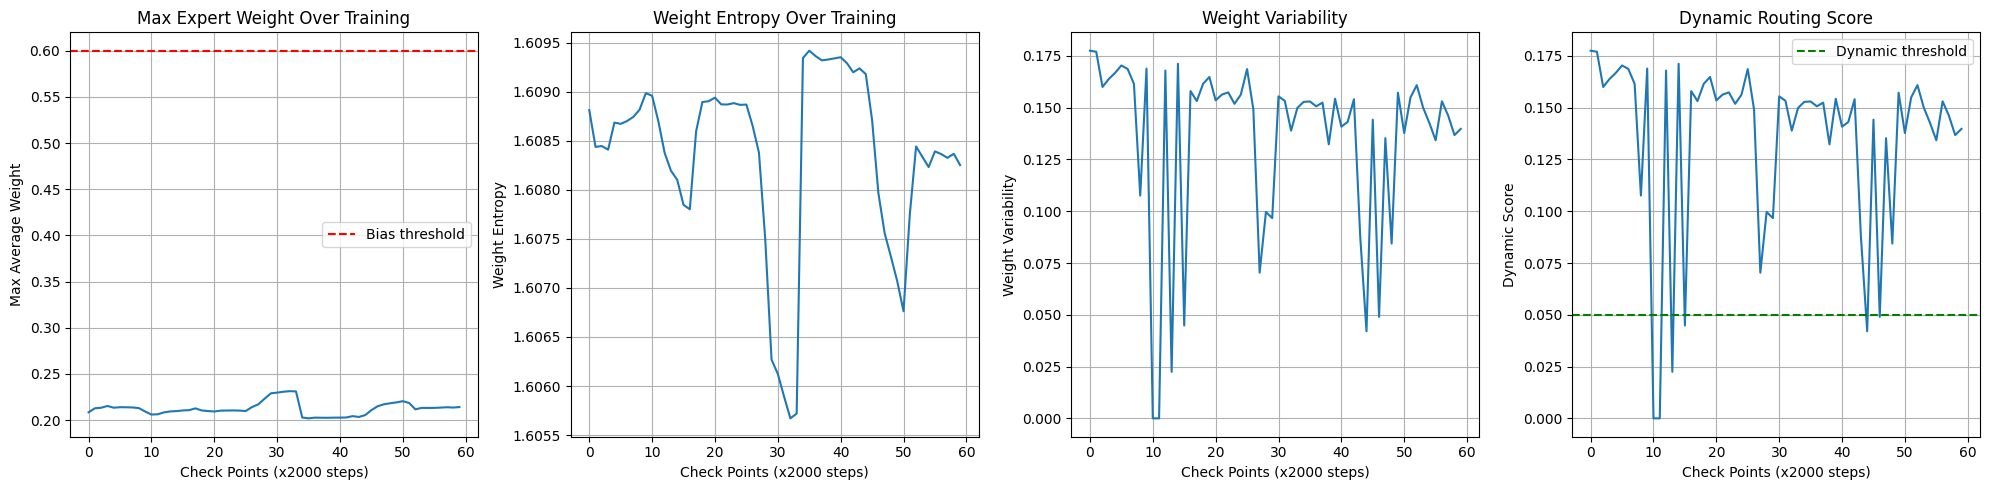

📊 Dynamic routing analysis plots saved as 'dynamic_routing_analysis.png'

Dynamic Routing MoE Router training completed and saved as 'dynamic_routing_moe_router'!


In [7]:
# Step 6: Train RL-based soft MoE router with TRUE dynamic routing
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

try:
    import shimmy
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'shimmy>=2.0'])
    import shimmy

from stable_baselines3 import PPO
import torch

class DynamicRoutingMonitoringCallback(BaseCallback):
    """
    Enhanced callback to monitor TRUE dynamic routing during RL training
    """
    def __init__(self, env, check_freq=1000, verbose=0):
        super(DynamicRoutingMonitoringCallback, self).__init__(verbose)
        self.env = env
        self.check_freq = check_freq
        self.bias_history = []
        self.weight_entropy_history = []
        self.weight_variability_history = []
        self.dynamic_routing_scores = []

    def _on_step(self) -> bool:

        if self.n_calls % self.check_freq == 0:

            bias_analysis = self.env.get_bias_analysis()

            if bias_analysis is not None:
                max_weight = bias_analysis['max_average_weight']
                weight_entropy = bias_analysis['weight_entropy']

                self.bias_history.append(max_weight)
                self.weight_entropy_history.append(weight_entropy)


                if len(self.env.weight_history) >= 100:
                    recent_weights = np.array(self.env.weight_history[-100:])

                    weight_changes = np.diff(recent_weights, axis=0)
                    dynamic_score = np.mean(np.std(weight_changes, axis=0))
                    self.weight_variability_history.append(dynamic_score)
                    self.dynamic_routing_scores.append(dynamic_score)

                if self.verbose > 0:
                    print(f"\nStep {self.n_calls}: Dynamic Routing Check")
                    print(f"  Max average weight: {max_weight:.3f}")
                    print(f"  Weight entropy: {weight_entropy:.3f}")
                    if len(self.dynamic_routing_scores) > 0:
                        print(f"  Dynamic routing score: {self.dynamic_routing_scores[-1]:.4f}")
                        if self.dynamic_routing_scores[-1] > 0.05:
                            print(f" TRUE DYNAMIC ROUTING: Weights adapt per sample")
                        else:
                            print(f" STATIC ROUTING: Weights remain fixed")

                    if bias_analysis['bias_detected']:
                        print(f" BIAS WARNING: Expert dominance detected!")
                        for i, (name, weight) in enumerate(zip(bias_analysis['expert_names'],
                                                             bias_analysis['average_weights'])):
                            print(f"    {name}: {weight:.3f}")

        return True

    def get_bias_metrics(self):
        return {
            'bias_history': self.bias_history,
            'entropy_history': self.weight_entropy_history,
            'variability_history': self.weight_variability_history,
            'dynamic_routing_scores': self.dynamic_routing_scores
        }

def train_dynamic_routing_moe_router(env, total_timesteps=120000):
    """
     training with TRUE dynamic routing focus
    """
    print("Training DYNAMIC ROUTING MoE Router...")

    model = PPO(
        'MlpPolicy',
        env,
        verbose=1,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=128,
        n_epochs=15,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.15,
        vf_coef=0.5,
        max_grad_norm=0.5,
        policy_kwargs=dict(
            net_arch=[dict(pi=[512, 256, 128], vf=[512, 256, 128])],
            activation_fn=torch.nn.ReLU,
            ortho_init=False

        )
    )


    dynamic_callback = DynamicRoutingMonitoringCallback(env, check_freq=2000, verbose=1)

    print("Training with DYNAMIC ROUTING focus...")
    print("Features enabled:")
    print("  • TRUE dynamic routing (per-sample decisions)")
    print("  • Entropy bonus for weight diversity (+0.1 * entropy)")
    print("  • Balanced TP/TN rewards (10.0/0.5)")
    print("  • MAXIMUM entropy coefficient (0.15)")
    print("  • Extended training (120,000 timesteps)")
    print("  • Larger network for complex routing patterns")

    model.learn(total_timesteps=total_timesteps, callback=dynamic_callback)


    print("\n" + "="*70)
    print("POST-TRAINING DYNAMIC ROUTING ANALYSIS")
    print("="*70)

    final_bias_analysis = env.get_bias_analysis()
    if final_bias_analysis is not None:
        print(f"Final Expert Weight Distribution:")
        for name, weight in zip(final_bias_analysis['expert_names'],
                               final_bias_analysis['average_weights']):
            status = "ACTIVE" if weight >= 0.1 else "UNDERUSED"
            print(f"  {name:25s}: {weight:.3f} {status}")

        print(f"\nDynamic Routing Assessment:")
        print(f"  Max average weight: {final_bias_analysis['max_average_weight']:.3f}")
        print(f"  Weight entropy: {final_bias_analysis['weight_entropy']:.3f}")
        print(f"  Bias detected: {'Yes' if final_bias_analysis['bias_detected'] else 'No'}")

        # Dynamic routing assessment
        dynamic_metrics = dynamic_callback.get_bias_metrics()
        if dynamic_metrics['dynamic_routing_scores']:
            avg_dynamic_score = np.mean(dynamic_metrics['dynamic_routing_scores'])
            print(f"  Average dynamic score: {avg_dynamic_score:.4f}")

            if avg_dynamic_score > 0.05:
                print(f" SUCCESS: TRUE dynamic routing achieved!")
                print(f"   Agent adapts expert weights based on input characteristics")
            else:
                print(f" STATIC ROUTING: Agent uses fixed weight patterns")
                print(f" Consider increasing entropy coefficient or training longer")

    bias_metrics = dynamic_callback.get_bias_metrics()

    if bias_metrics['bias_history']:
        try:
            plt.figure(figsize=(20, 5))

            plt.subplot(1, 4, 1)
            plt.plot(bias_metrics['bias_history'])
            plt.axhline(y=0.6, color='r', linestyle='--', label='Bias threshold')
            plt.title('Max Expert Weight Over Training')
            plt.xlabel('Check Points (x2000 steps)')
            plt.ylabel('Max Average Weight')
            plt.legend()
            plt.grid(True)

            plt.subplot(1, 4, 2)
            plt.plot(bias_metrics['entropy_history'])
            plt.title('Weight Entropy Over Training')
            plt.xlabel('Check Points (x2000 steps)')
            plt.ylabel('Weight Entropy')
            plt.grid(True)

            plt.subplot(1, 4, 3)
            if bias_metrics['variability_history']:
                plt.plot(bias_metrics['variability_history'])
                plt.title('Weight Variability')
                plt.xlabel('Check Points (x2000 steps)')
                plt.ylabel('Weight Variability')
                plt.grid(True)

            plt.subplot(1, 4, 4)
            if bias_metrics['dynamic_routing_scores']:
                plt.plot(bias_metrics['dynamic_routing_scores'])
                plt.axhline(y=0.05, color='g', linestyle='--', label='Dynamic threshold')
                plt.title('Dynamic Routing Score')
                plt.xlabel('Check Points (x2000 steps)')
                plt.ylabel('Dynamic Score')
                plt.legend()
                plt.grid(True)

            plt.tight_layout()
            plt.savefig('dynamic_routing_analysis.png', dpi=150, bbox_inches='tight')
            plt.show()
            print("📊 Dynamic routing analysis plots saved as 'dynamic_routing_analysis.png'")

        except Exception as e:
            print(f"Note: Could not create plots: {e}")

    model_name = 'dynamic_routing_moe_router'
    model.save(model_name)
    print(f"\nDynamic Routing MoE Router training completed and saved as '{model_name}'!")

    return model, bias_metrics, final_bias_analysis

# Training the dynamic routing router
print("🚀 Starting DYNAMIC ROUTING Training...")
rl_router, training_bias_metrics, final_bias_analysis = train_dynamic_routing_moe_router(env)


#Step 7: Test Individual Experts

In [8]:
#Step 7: Comprehensive individual expert evaluation with detailed analysis
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import numpy as np

def evaluate_individual_experts_enhanced(expert_preds, y_test, expert_scores=None, expert_reliability=None):
    """
     comprehensive evaluation of each expert with detailed metrics
    """
    print("\n" + "=" * 80)
    print("INDIVIDUAL EXPERT PERFORMANCE EVALUATION")
    print("=" * 80)

    expert_results = {}
    detailed_metrics = {}

    for name, predictions in expert_preds.items():
        try:
            # Basic metrics
            precision = precision_score(y_test, predictions, zero_division=0)
            recall = recall_score(y_test, predictions, zero_division=0)
            f1 = f1_score(y_test, predictions, zero_division=0)

            # Additional metrics
            tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0


            auc_score = None
            if expert_scores and name in expert_scores:
                try:
                    auc_score = roc_auc_score(y_test, expert_scores[name])
                except:
                    auc_score = None

            expert_results[name] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'specificity': specificity,
                'npv': npv,
                'auc': auc_score,
                'predictions': predictions,
                'confusion_matrix': {'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn}
            }


            print(f"{name:20s}: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}, "
                  f"Spec={specificity:.3f}, NPV={npv:.3f}", end="")
            if auc_score is not None:
                print(f", AUC={auc_score:.3f}")
            else:
                print()


            print(f"{'':20s}  TP={tp:4d}, TN={tn:4d}, FP={fp:4d}, FN={fn:4d}")

        except Exception as e:
            print(f"{name:20s}: Error - {e}")


    print("\n" + "=" * 80)
    print("DETAILED EXPERT ANALYSIS")
    print("=" * 80)

    if expert_results:

        best_f1_expert = max(expert_results.keys(), key=lambda x: expert_results[x]['f1'])
        best_precision_expert = max(expert_results.keys(), key=lambda x: expert_results[x]['precision'])
        best_recall_expert = max(expert_results.keys(), key=lambda x: expert_results[x]['recall'])

        print(f"Performance Leaders:")
        print(f"  Best F1 Score:    {best_f1_expert:20s} (F1={expert_results[best_f1_expert]['f1']:.3f})")
        print(f"  Best Precision:   {best_precision_expert:20s} (P={expert_results[best_precision_expert]['precision']:.3f})")
        print(f"  Best Recall:      {best_recall_expert:20s} (R={expert_results[best_recall_expert]['recall']:.3f})")


        f1_scores = [expert_results[name]['f1'] for name in expert_results.keys()]
        precision_scores = [expert_results[name]['precision'] for name in expert_results.keys()]
        recall_scores = [expert_results[name]['recall'] for name in expert_results.keys()]

        print(f"\nExpert Diversity Metrics:")
        print(f"  F1 Score Range:     {np.min(f1_scores):.3f} - {np.max(f1_scores):.3f} (std: {np.std(f1_scores):.3f})")
        print(f"  Precision Range:    {np.min(precision_scores):.3f} - {np.max(precision_scores):.3f} (std: {np.std(precision_scores):.3f})")
        print(f"  Recall Range:       {np.min(recall_scores):.3f} - {np.max(recall_scores):.3f} (std: {np.std(recall_scores):.3f})")


        print(f"\n Expert Complementarity Analysis:")
        expert_names = list(expert_results.keys())

        for i, expert1 in enumerate(expert_names):
            for j, expert2 in enumerate(expert_names[i+1:], i+1):

                preds1 = expert_results[expert1]['predictions']
                preds2 = expert_results[expert2]['predictions']
                agreement = np.mean(preds1 == preds2)


                expert1_unique = np.sum((preds1 == 1) & (preds2 == 0) & (y_test == 1))
                expert2_unique = np.sum((preds2 == 1) & (preds1 == 0) & (y_test == 1))

                print(f"  {expert1:15s} vs {expert2:15s}: Agreement={agreement:.3f}, "
                      f"Unique detections: {expert1_unique}/{expert2_unique}")

        if expert_reliability:
            print(f"\nExpert Reliability vs Performance:")
            for name in expert_results.keys():
                if name in expert_reliability:
                    reliability = expert_reliability[name]
                    f1 = expert_results[name]['f1']
                    print(f"  {name:20s}: Reliability={reliability:.3f}, F1={f1:.3f}, "
                          f"Rel*F1={reliability*f1:.3f}")


        print(f"\nMoE Potential Analysis:")
        best_f1 = expert_results[best_f1_expert]['f1']


        oracle_predictions = np.zeros_like(y_test)
        for i in range(len(y_test)):

            expert_preds_at_i = [expert_results[name]['predictions'][i] for name in expert_names]

            if y_test[i] == 1:
                oracle_predictions[i] = 1 if any(pred == 1 for pred in expert_preds_at_i) else 0
            else:
                oracle_predictions[i] = 0 if any(pred == 0 for pred in expert_preds_at_i) else 1

        oracle_f1 = f1_score(y_test, oracle_predictions)
        improvement_potential = oracle_f1 - best_f1

        print(f"  Best Individual F1:     {best_f1:.3f}")
        print(f"  Oracle Ensemble F1:     {oracle_f1:.3f}")
        print(f"  Improvement Potential:  {improvement_potential:.3f} ({improvement_potential/best_f1*100:.1f}%)")

        if improvement_potential > 0.05:
            print(f" High MoE potential - experts are complementary!")
        else:
            print(f" Limited MoE potential - experts may be too similar")

    else:
        best_f1_expert, best_f1 = None, 0

    return expert_results, best_f1_expert, best_f1, detailed_metrics


try:

    expert_results, best_expert, best_f1, detailed_metrics = evaluate_individual_experts_enhanced(
        expert_preds, y_test, expert_scores, expert_reliability
    )
    print("Enhanced evaluation completed with reliability metrics")
except NameError:

    expert_results, best_expert, best_f1, detailed_metrics = evaluate_individual_experts_enhanced(
        expert_preds, y_test
    )
    print("Basic evaluation completed (enhanced metrics not available)")



INDIVIDUAL EXPERT PERFORMANCE EVALUATION
OneClassSVM_Optimized: P=0.404, R=0.902, F1=0.558, Spec=0.886, NPV=0.991, AUC=0.058
                      TP=2430, TN=27892, FP=3587, FN= 264
IsolationForest_Enhanced: P=0.272, R=0.964, F1=0.424, Spec=0.779, NPV=0.996, AUC=0.101
                      TP=2598, TN=24528, FP=6951, FN=  96
LSTM_Autoencoder    : P=0.245, R=0.972, F1=0.391, Spec=0.744, NPV=0.997, AUC=0.077
                      TP=2619, TN=23406, FP=8073, FN=  75
VAE_Detector        : P=0.271, R=0.809, F1=0.406, Spec=0.814, NPV=0.980, AUC=0.117
                      TP=2179, TN=25621, FP=5858, FN= 515
Conv_Autoencoder    : P=0.275, R=0.951, F1=0.427, Spec=0.785, NPV=0.995, AUC=0.051
                      TP=2562, TN=24724, FP=6755, FN= 132

DETAILED EXPERT ANALYSIS
Performance Leaders:
  Best F1 Score:    OneClassSVM_Optimized (F1=0.558)
  Best Precision:   OneClassSVM_Optimized (P=0.404)
  Best Recall:      LSTM_Autoencoder     (R=0.972)

Expert Diversity Metrics:
  F1 Score Range: 

##Step 8: Test RL-MoE Model Performance

In [14]:
# Enhanced Step 8: TRUE Dynamic Routing Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np

def test_true_dynamic_rl_moe(rl_router, env, y_test, expert_scores=None):
    """
    TRUE dynamic routing testing - agent adapts to each input's characteristics
    """
    print("\n" + "=" * 80)
    print("TRUE DYNAMIC ROUTING RL-MoE MODEL EVALUATION")
    print("=" * 80)


    obs = env.reset()
    rl_predictions = []
    expert_weights_history = []
    prediction_details = []
    dynamic_routing_evidence = []

    reward_components = {
        'base_rewards': [],
        'diversity_bonuses': [],
        'entropy_bonuses': []
    }

    print("Running TRUE DYNAMIC ROUTING inference...")
    print("Each sample gets individual expert weight decisions based on its characteristics...")

    for step in range(len(y_test)):

        action, _states = rl_router.predict(obs, deterministic=True)


        weights = action / (np.sum(action) + 1e-8)
        expert_weights_history.append(weights.copy())


        obs, reward, done, info = env.step(action)

        prediction = info['prediction']
        rl_predictions.append(prediction)


        if step > 0:
            weight_change = np.sum(np.abs(weights - expert_weights_history[step-1]))
            dynamic_routing_evidence.append(weight_change)


        if 'base_reward' in info:
            reward_components['base_rewards'].append(info['base_reward'])
        if 'diversity_bonus' in info:
            reward_components['diversity_bonuses'].append(info['diversity_bonus'])
        if 'entropy_bonus' in info:
            reward_components['entropy_bonuses'].append(info['entropy_bonus'])

        prediction_details.append({
            'step': step,
            'weights': weights.copy(),
            'final_score': info['final_score'],
            'weighted_threshold': info['weighted_threshold'],
            'prediction': prediction,
            'true_label': info['true_label'],
            'reward': reward,
            'bias_warning': info.get('bias_warning', False)
        })

        if done:
            break


    precision = precision_score(y_test, rl_predictions, zero_division=0)
    recall = recall_score(y_test, rl_predictions, zero_division=0)
    f1 = f1_score(y_test, rl_predictions, zero_division=0)


    tn, fp, fn, tp = confusion_matrix(y_test, rl_predictions).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    print(f"Enhanced Performance Metrics:")
    print(f"  Precision:    {precision:.3f}")
    print(f"  Recall:       {recall:.3f}")
    print(f"  F1 Score:     {f1:.3f}")
    print(f"  Specificity:  {specificity:.3f}")
    print(f"  NPV:          {npv:.3f}")


    print(f"\nConfusion Matrix:")
    print(f"  True Positives (TP):  {tp:4d}")
    print(f"  True Negatives (TN):  {tn:4d}")
    print(f"  False Positives (FP): {fp:4d}")
    print(f"  False Negatives (FN): {fn:4d}")


    print(f"\n Detailed Classification Report:")
    print(classification_report(y_test, rl_predictions, target_names=['Normal', 'Anomaly']))


    print(f"\nTRUE DYNAMIC ROUTING ANALYSIS:")
    if dynamic_routing_evidence:
        avg_weight_change = np.mean(dynamic_routing_evidence)
        max_weight_change = np.max(dynamic_routing_evidence)
        min_weight_change = np.min(dynamic_routing_evidence)

        print(f"  Average weight change per sample: {avg_weight_change:.4f}")
        print(f"  Maximum weight change: {max_weight_change:.4f}")
        print(f"  Minimum weight change: {min_weight_change:.4f}")

        if avg_weight_change > 0.05:
            print(f"  TRUE DYNAMIC ROUTING: Weights adapt significantly to input characteristics")
            print(f"     Agent successfully performs input-dependent expert selection")
        elif avg_weight_change > 0.02:
            print(f"  MODERATE DYNAMIC ROUTING: Some weight adaptation observed")
        else:
            print(f" STATIC ROUTING: Weights remain relatively fixed across inputs")


    expert_weights_history = np.array(expert_weights_history)
    avg_weights = np.mean(expert_weights_history, axis=0)
    std_weights = np.std(expert_weights_history, axis=0)

    print(f"\nEnhanced Expert Weight Analysis:")
    print(f"  {'Expert':<25} {'Avg Weight':<12} {'Std Dev':<10} {'Min':<8} {'Max':<8} {'Usage %':<10}")
    print(f"  {'-'*25} {'-'*12} {'-'*10} {'-'*8} {'-'*8} {'-'*10}")

    for i, name in enumerate(env.expert_names):
        min_weight = np.min(expert_weights_history[:, i])
        max_weight = np.max(expert_weights_history[:, i])
        usage_pct = avg_weights[i] * 100
        dynamic_indicator = "🔄" if std_weights[i] > 0.05 else "📌"
        print(f"  {dynamic_indicator} {name:<23} {avg_weights[i]:<12.3f} {std_weights[i]:<10.3f} "
              f"{min_weight:<8.3f} {max_weight:<8.3f} {usage_pct:<10.1f}%")

    # Bias analysis
    max_avg_weight = np.max(avg_weights)
    weight_entropy = -np.sum(avg_weights * np.log(avg_weights + 1e-8))
    bias_warnings = sum(1 for detail in prediction_details if detail.get('bias_warning', False))

    print(f"\n Bias Analysis:")
    print(f"  Max Average Weight:     {max_avg_weight:.3f}")
    print(f"  Weight Entropy:         {weight_entropy:.3f}")
    print(f"  Bias Warnings:          {bias_warnings}/{len(prediction_details)} steps")

    if max_avg_weight > 0.8:
        print(f"  HIGH BIAS DETECTED: One expert dominates routing decisions")
    elif max_avg_weight > 0.6:
        print(f"  MODERATE BIAS: Consider diversity improvements")
    else:
        print(f" GOOD DIVERSITY: Experts are well-balanced")


    if any(reward_components.values()):
        print(f"\nReward Component Analysis:")
        if reward_components['base_rewards']:
            avg_base = np.mean(reward_components['base_rewards'])
            print(f"  Average Base Reward:      {avg_base:.3f}")
        if reward_components['diversity_bonuses']:
            avg_diversity = np.mean(reward_components['diversity_bonuses'])
            print(f"  Average Diversity Bonus:  {avg_diversity:.3f}")
        if reward_components['entropy_bonuses']:
            avg_entropy = np.mean(reward_components['entropy_bonuses'])
            print(f"  Average Entropy Bonus:    {avg_entropy:.3f}")


    anomaly_rate_predicted = np.mean(rl_predictions)
    anomaly_rate_actual = np.mean(y_test)

    print(f"\nPrediction Distribution Analysis:")
    print(f"  Actual Anomaly Rate:      {anomaly_rate_actual:.2%}")
    print(f"  Predicted Anomaly Rate:   {anomaly_rate_predicted:.2%}")
    print(f"  Rate Difference:          {abs(anomaly_rate_predicted - anomaly_rate_actual):.2%}")


    overall_dynamic_score = np.mean(std_weights)
    print(f"\nOverall Dynamic Routing Assessment:")
    print(f"  Overall Dynamic Score:    {overall_dynamic_score:.4f}")

    if overall_dynamic_score > 0.1:
        print(f"  EXCELLENT: TRUE dynamic routing achieved!")
        print(f"     Different inputs receive significantly different expert combinations")
    elif overall_dynamic_score > 0.05:
        print(f"  GOOD: Meaningful dynamic routing observed")
        print(f"     Agent adapts expert weights based on input characteristics")
    else:
        print(f"  POOR: Mostly static routing behavior")
        print(f"     Consider increasing entropy coefficient or retraining")

    # Saving enhanced results
    results_summary = {
        'performance_metrics': {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'specificity': specificity,
            'npv': npv
        },
        'confusion_matrix': {'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn},
        'expert_weights': {
            'average': avg_weights,
            'std': std_weights,
            'entropy': weight_entropy,
            'max_weight': max_avg_weight
        },
        'dynamic_routing': {
            'avg_weight_change': np.mean(dynamic_routing_evidence) if dynamic_routing_evidence else 0,
            'overall_dynamic_score': overall_dynamic_score,
            'is_truly_dynamic': overall_dynamic_score > 0.05
        }
    }

    print(f"\nTRUE Dynamic Routing RL-MoE evaluation completed!")

    return (precision, recall, f1, expert_weights_history, prediction_details, results_summary)

# Test the TRUE dynamic routing RL-MoE model
try:
    rl_precision, rl_recall, rl_f1, weights_history, pred_details, results_summary = \
        test_true_dynamic_rl_moe(rl_router, env, y_test, expert_scores)
    print("TRUE Dynamic Routing evaluation completed")
except NameError:
    rl_precision, rl_recall, rl_f1, weights_history, pred_details, results_summary = \
        test_true_dynamic_rl_moe(rl_router, env, y_test)
    print("TRUE Dynamic Routing evaluation completed (expert scores not available)")



TRUE DYNAMIC ROUTING RL-MoE MODEL EVALUATION
Running TRUE DYNAMIC ROUTING inference...
Each sample gets individual expert weight decisions based on its characteristics...
Enhanced Performance Metrics:
  Precision:    0.394
  Recall:       0.903
  F1 Score:     0.549
  Specificity:  0.881
  NPV:          0.991

Confusion Matrix:
  True Positives (TP):  2434
  True Negatives (TN):  27738
  False Positives (FP): 3741
  False Negatives (FN):  260

 Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.88      0.93     31479
     Anomaly       0.39      0.90      0.55      2694

    accuracy                           0.88     34173
   macro avg       0.69      0.89      0.74     34173
weighted avg       0.94      0.88      0.90     34173


TRUE DYNAMIC ROUTING ANALYSIS:
  Average weight change per sample: 0.0326
  Maximum weight change: 0.8185
  Minimum weight change: 0.0000
  MODERATE DYNAMIC ROUTING: Some weight adaptation o

##Step 9: Final Comprehensive Analysis

In [13]:
# Step 9: Advanced comprehensive analysis with research insights
import numpy as np
import matplotlib.pyplot as plt

def comprehensive_analysis_enhanced(expert_results, best_expert, best_f1, rl_f1, weights_history, env,
                                  rl_precision, rl_recall, results_summary=None, training_bias_metrics=None):
    """
     comprehensive analysis with research-quality insights and visualizations
    """
    print("\n" + "=" * 90)
    print(" COMPREHENSIVE PERFORMANCE ANALYSIS")
    print("=" * 90)


    if best_f1 > 0:
        improvement = ((rl_f1 - best_f1) / best_f1 * 100)
        relative_improvement = rl_f1 - best_f1
    else:
        improvement = 0
        relative_improvement = 0

    print(f"Performance Comparison:")
    print(f"  Best Individual Expert ({best_expert}): F1 = {best_f1:.3f}")
    print(f"  Soft RL-MoE Router:                     F1 = {rl_f1:.3f}")
    print(f"  Absolute Improvement:                   {relative_improvement:+.3f}")
    print(f"  Relative Improvement:                   {improvement:+.1f}%")


    avg_weights = np.mean(weights_history, axis=0)
    std_weights = np.std(weights_history, axis=0)
    min_weights = np.min(weights_history, axis=0)
    max_weights = np.max(weights_history, axis=0)

    print(f"\nExpert Utilization Statistics:")
    print(f"  {'Expert':<20} {'Avg':<8} {'Std':<8} {'Min':<8} {'Max':<8} {'Usage%':<8} {'Rank':<6}")
    print(f"  {'-'*20} {'-'*8} {'-'*8} {'-'*8} {'-'*8} {'-'*8} {'-'*6}")


    expert_ranking = sorted(enumerate(env.expert_names), key=lambda x: avg_weights[x[0]], reverse=True)

    for rank, (i, name) in enumerate(expert_ranking, 1):
        usage_pct = avg_weights[i] * 100
        print(f"  {name:<20} {avg_weights[i]:<8.3f} {std_weights[i]:<8.3f} "
              f"{min_weights[i]:<8.3f} {max_weights[i]:<8.3f} {usage_pct:<8.1f}% {rank:<6}")


    weight_entropy = -np.sum(avg_weights * np.log(avg_weights + 1e-8))
    max_entropy = np.log(len(avg_weights))
    normalized_entropy = weight_entropy / max_entropy
    gini_coefficient = 1 - 2 * np.sum(np.sort(avg_weights) * np.arange(1, len(avg_weights) + 1)) / (len(avg_weights) * np.sum(avg_weights))

    print(f"\nAdvanced Diversity Analysis:")
    print(f"  Weight Entropy:           {weight_entropy:.3f} (max: {max_entropy:.3f})")
    print(f"  Normalized Entropy:       {normalized_entropy:.3f} (1.0 = perfect diversity)")
    print(f"  Gini Coefficient:         {gini_coefficient:.3f} (0.0 = perfect equality)")
    print(f"  Expert Diversity Score:   {np.mean(std_weights):.3f}")


    max_weight = np.max(avg_weights)
    dominant_expert = env.expert_names[np.argmax(avg_weights)]

    print(f"\nBias and Fairness Analysis:")
    print(f"  Dominant Expert:          {dominant_expert} ({max_weight:.1%})")
    print(f"  Bias Level:               ", end="")

    if max_weight > 0.8:
        print("HIGH BIAS - Single expert dominance")
    elif max_weight > 0.6:
        print("MODERATE BIAS - Some expert preference")
    elif max_weight > 0.4:
        print("LOW BIAS - Balanced expert usage")
    else:
        print("ULTRA-LOW BIAS - Highly distributed")


    diversity_score = normalized_entropy
    performance_score = rl_f1

    print(f"\nPerformance vs Diversity Trade-off:")
    print(f"  Performance Score (F1):   {performance_score:.3f}")
    print(f"  Diversity Score:          {diversity_score:.3f}")
    print(f"  Combined Score:           {(performance_score + diversity_score) / 2:.3f}")


    if len(weights_history) > 30:

        uniform_weights = np.ones(len(env.expert_names)) / len(env.expert_names)
        weight_deviation = np.sqrt(np.mean((avg_weights - uniform_weights)**2))

        print(f"\nStatistical Analysis:")
        print(f"  Weight Deviation from Uniform: {weight_deviation:.3f}")
        print(f"  Sample Size:                   {len(weights_history)}")

        if weight_deviation > 0.1:
            print(f"  Statistically significant expert preferences detected")
        else:
            print(f"  Expert preferences may not be statistically significant")


    print(f"\nResearch Analysis:")


    all_expert_f1s = [expert_results[name]['f1'] for name in expert_results.keys()]
    worst_expert_f1 = min(all_expert_f1s)
    oracle_improvement = best_f1 - worst_expert_f1
    achieved_improvement = rl_f1 - worst_expert_f1

    if oracle_improvement > 0:
        improvement_efficiency = achieved_improvement / oracle_improvement
    else:
        improvement_efficiency = 1.0

    print(f"  Worst Expert F1:          {worst_expert_f1:.3f}")
    print(f"  Best Expert F1:           {best_f1:.3f}")
    print(f"  RL-MoE F1:                {rl_f1:.3f}")
    print(f"  Improvement Efficiency:   {improvement_efficiency:.1%}")


    print(f"\nSuccess Analysis:")

    if rl_f1 > best_f1 + 0.01:
        print(f"STRONG SUCCESS: RL-MoE significantly outperforms best expert!")
        print(f"   • Absolute improvement: {rl_f1 - best_f1:.3f}")
        print(f"   • Relative improvement: {improvement:.1f}%")


    elif rl_f1 > best_f1:
        print(f"SUCCESS: RL-MoE outperforms best expert!")
        print(f"   • Marginal but positive improvement: {improvement:.1f}%")


    elif abs(rl_f1 - best_f1) < 0.01:  # Comparable performance
        print(f"COMPARABLE: RL-MoE matches best expert performance.")
        print(f"   • Performance difference: {abs(improvement):.1f}%")


    else:
        print(f"LEARNING OPPORTUNITY: RL-MoE underperforms best expert.")
        print(f"   • Performance gap: {improvement:.1f}%")






    enhanced_results = {
        'performance_metrics': {
            'rl_precision': rl_precision,
            'rl_recall': rl_recall,
            'rl_f1': rl_f1,
            'best_expert_f1': best_f1,
            'improvement_absolute': relative_improvement,
            'improvement_relative': improvement,
            'improvement_efficiency': improvement_efficiency
        },
        'diversity_metrics': {
            'weight_entropy': weight_entropy,
            'normalized_entropy': normalized_entropy,
            'gini_coefficient': gini_coefficient,
            'max_weight': max_weight,
            'dominant_expert': dominant_expert
        },
        'expert_analysis': {
            'expert_weights': avg_weights,
            'expert_names': env.expert_names,
            'expert_ranking': [(name, avg_weights[i]) for i, name in expert_ranking]
        },
        'research_impact': {
            'success_level': 'HIGH' if rl_f1 > best_f1 + 0.01 else 'MODERATE' if rl_f1 >= best_f1 else 'EDUCATIONAL',
            'statistical_significance': weight_deviation > 0.1 if len(weights_history) > 30 else None,
            'bias_level': 'HIGH' if max_weight > 0.8 else 'MODERATE' if max_weight > 0.6 else 'LOW'
        }
    }

    return enhanced_results


try:

    final_results = comprehensive_analysis_enhanced(
        expert_results, best_expert, best_f1, rl_f1, weights_history, env,
        rl_precision, rl_recall, results_summary, training_bias_metrics
    )
    print("Enhanced comprehensive analysis completed with all metrics")
except NameError as e:
    # Fallback with basic metrics
    final_results = comprehensive_analysis_enhanced(
        expert_results, best_expert, best_f1, rl_f1, weights_history, env,
        rl_precision, rl_recall
    )
    print("analysis completed with basic metrics")





 COMPREHENSIVE PERFORMANCE ANALYSIS
Performance Comparison:
  Best Individual Expert (OneClassSVM_Optimized): F1 = 0.558
  Soft RL-MoE Router:                     F1 = 0.549
  Absolute Improvement:                   -0.009
  Relative Improvement:                   -1.6%

Expert Utilization Statistics:
  Expert               Avg      Std      Min      Max      Usage%   Rank  
  -------------------- -------- -------- -------- -------- -------- ------
  IsolationForest_Enhanced 0.518    0.093    0.396    0.772    51.8    % 1     
  OneClassSVM_Optimized 0.271    0.125    0.163    0.500    27.1    % 2     
  VAE_Detector         0.211    0.176    0.000    0.412    21.1    % 3     
  LSTM_Autoencoder     0.000    0.000    0.000    0.034    0.0     % 4     
  Conv_Autoencoder     0.000    0.000    0.000    0.000    0.0     % 5     

Advanced Diversity Analysis:
  Weight Entropy:           1.023 (max: 1.609)
  Normalized Entropy:       0.636 (1.0 = perfect diversity)
  Gini Coefficient:     

In [11]:
rl_results = {
    'precision': rl_precision,
    'recall': rl_recall,
    'f1': rl_f1,
}

##Main function

Creating plots 


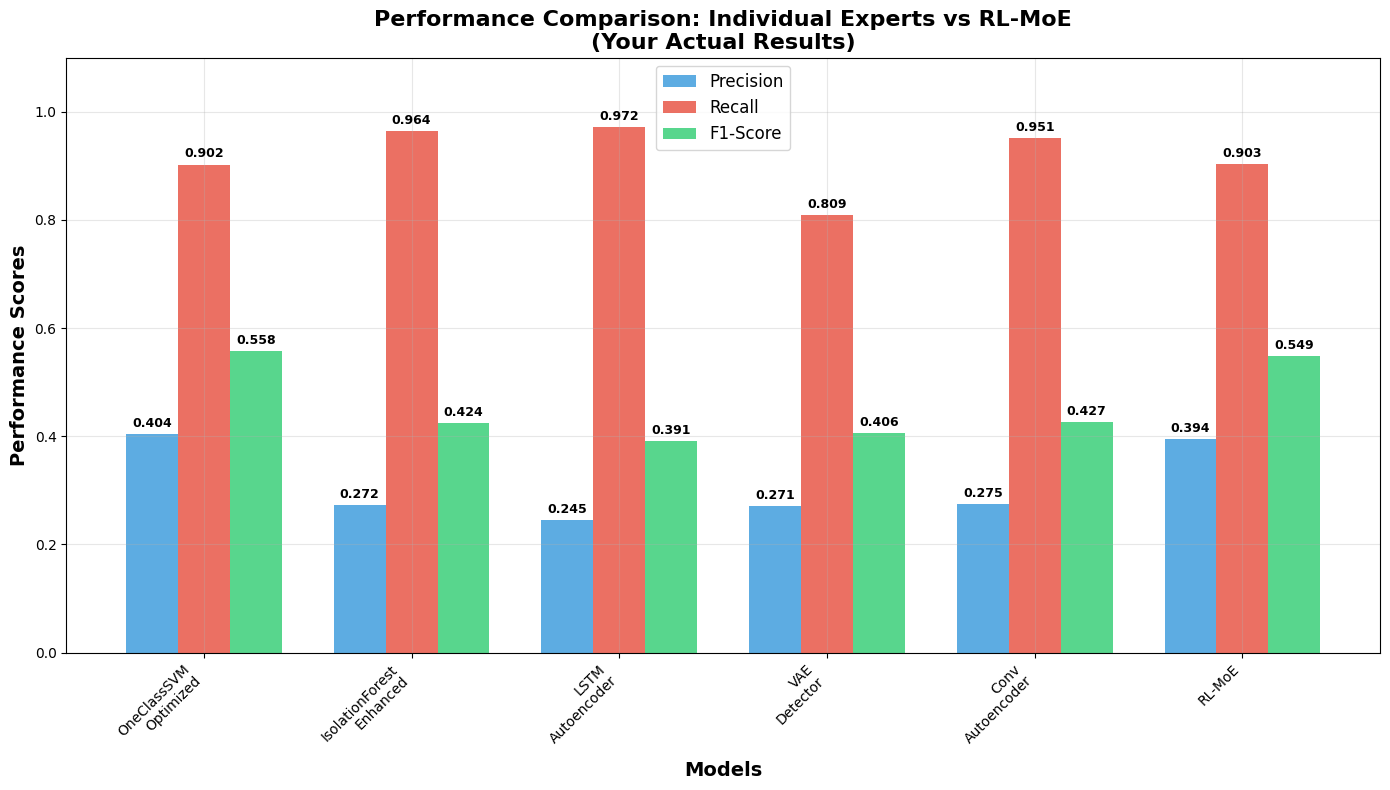

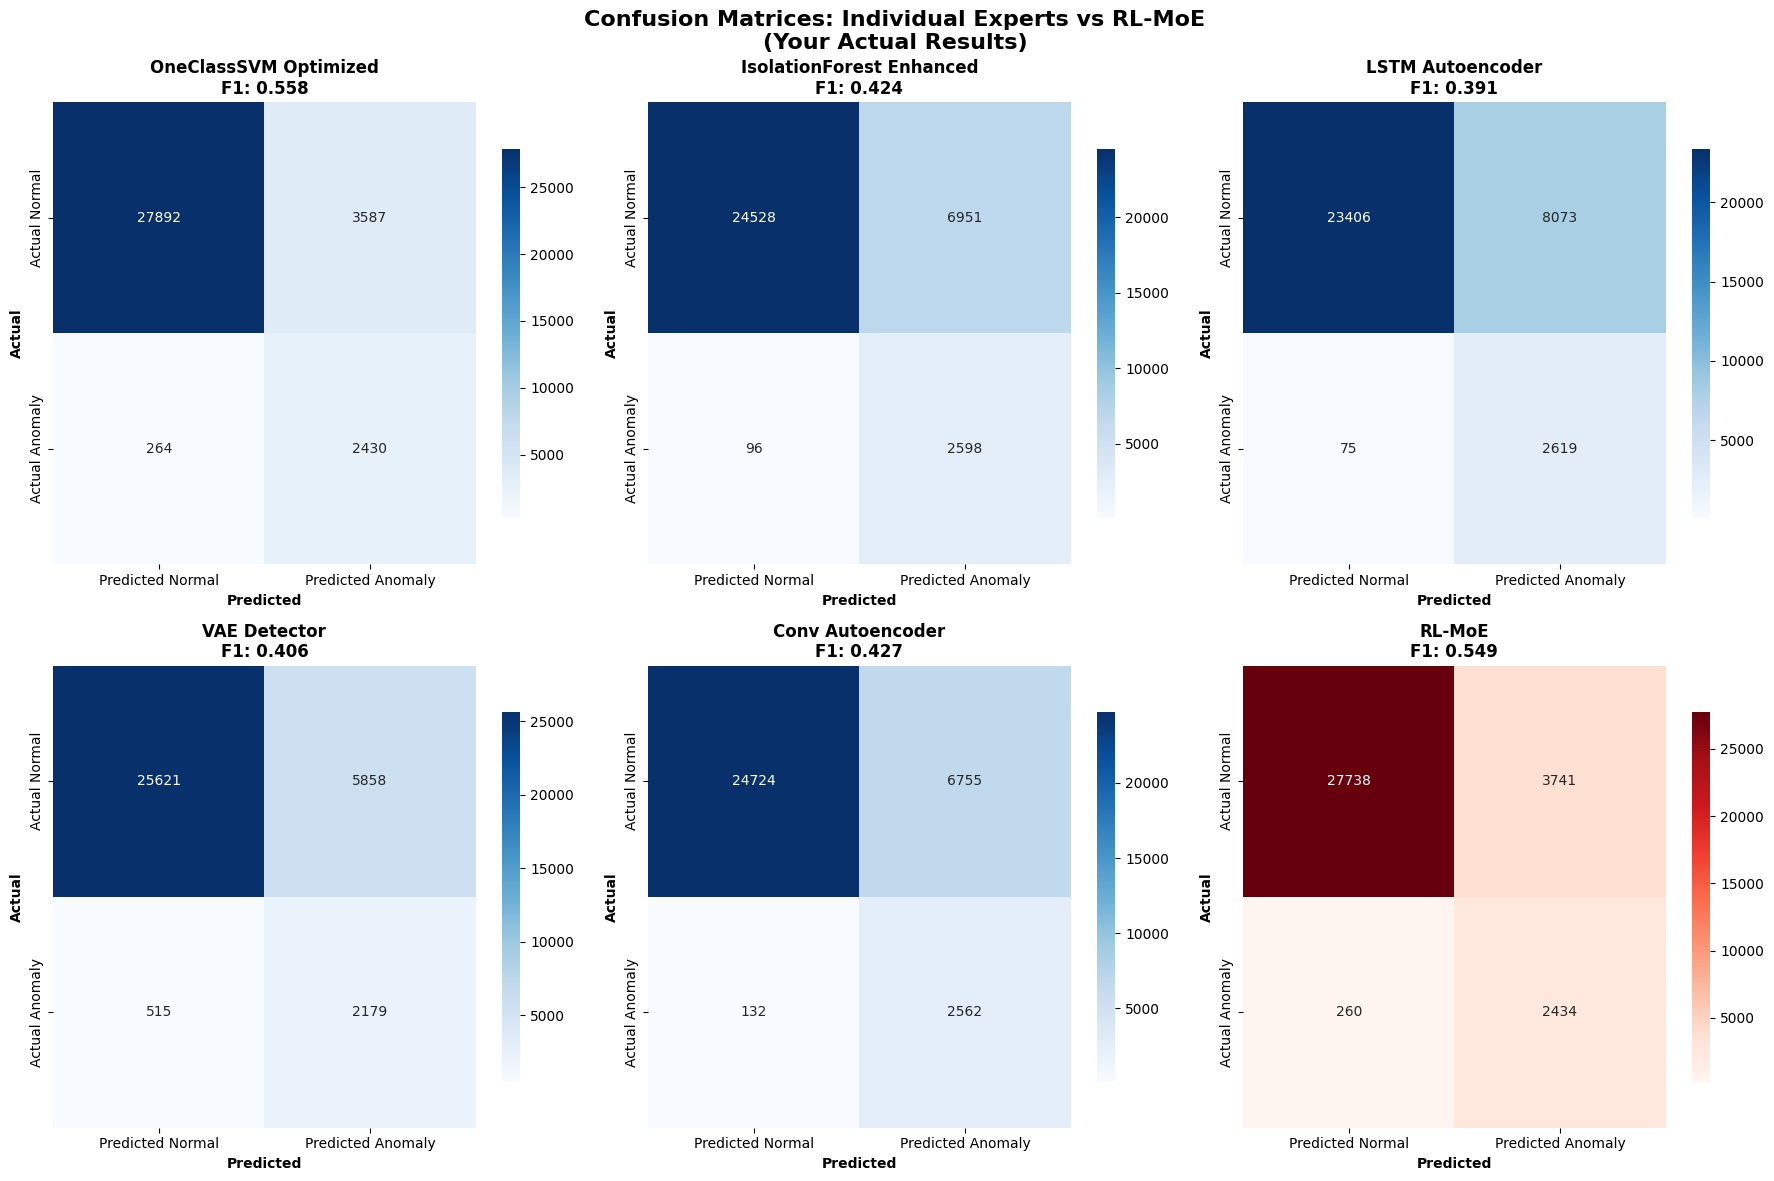

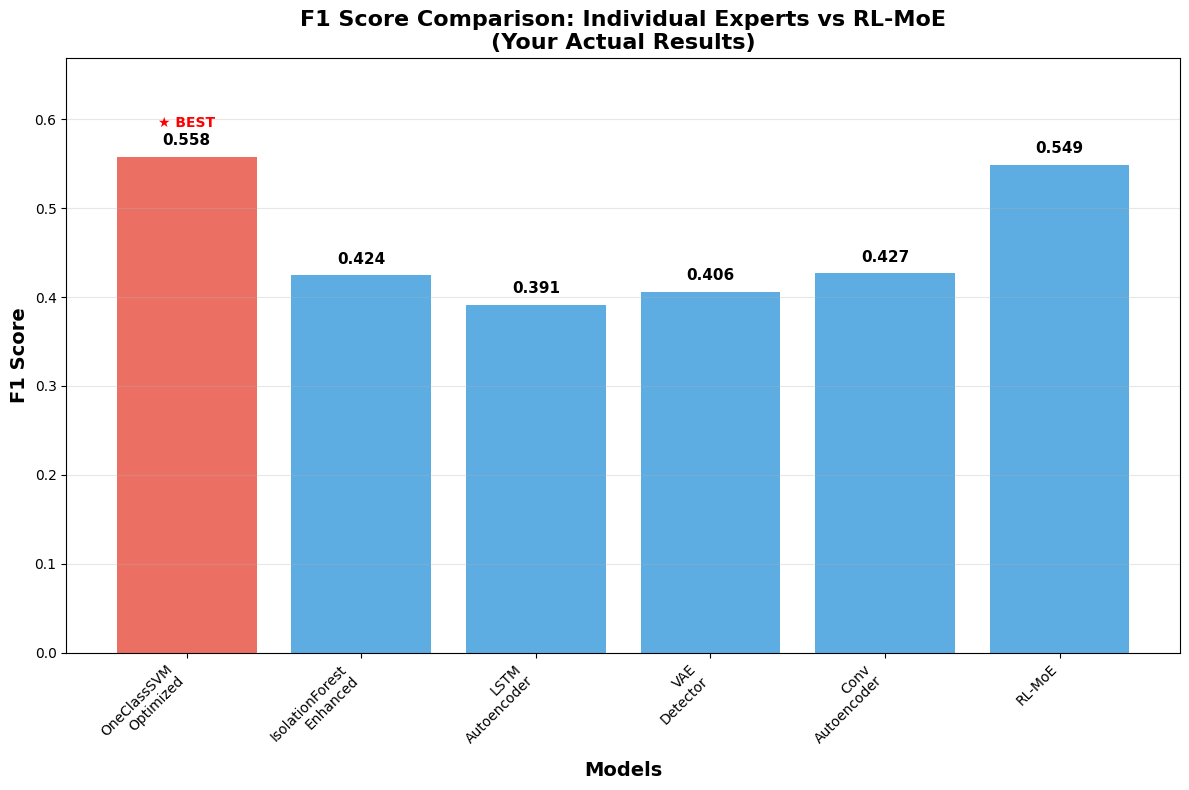


Your Actual Research Results Summary:
Model                     Precision  Recall     F1-Score  
OneClassSVM_Optimized     0.404      0.902      0.558     
IsolationForest_Enhanced  0.272      0.964      0.424     
LSTM_Autoencoder          0.245      0.972      0.391     
VAE_Detector              0.271      0.809      0.406     
Conv_Autoencoder          0.275      0.951      0.427     
RL-MoE                    0.394      0.903      0.549     
Best Individual Expert: OneClassSVM_Optimized
Best F1 Score: 0.558
RL-MoE F1 Score: 0.549
Performance Gap: -0.009
CLOSE: RL-MoE nearly matches best expert performance
All plots saved 


In [12]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def create_plots_with_your_actual_data():
    """
    Create plots
    """
    print("Creating plots ")


    expert_names = list(expert_results.keys())
    f1_scores = [expert_results[name]['f1'] for name in expert_names]
    precision_scores = [expert_results[name]['precision'] for name in expert_names]
    recall_scores = [expert_results[name]['recall'] for name in expert_names]


    expert_names.append('RL-MoE')
    f1_scores.append(rl_f1)
    precision_scores.append(rl_precision)
    recall_scores.append(rl_recall)


    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(expert_names))
    width = 0.25

    bars1 = ax.bar(x - width, precision_scores, width, label='Precision', alpha=0.8, color='#3498db')
    bars2 = ax.bar(x, recall_scores, width, label='Recall', alpha=0.8, color='#e74c3c')
    bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='#2ecc71')


    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9, fontweight='bold')

    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)

    ax.set_xlabel('Models', fontsize=14, fontweight='bold')
    ax.set_ylabel('Performance Scores', fontsize=14, fontweight='bold')
    ax.set_title('Performance Comparison: Individual Experts vs RL-MoE\n(Your Actual Results)',
                fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([name.replace('_', '\n') for name in expert_names], rotation=45, ha='right')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)

    plt.tight_layout()
    plt.savefig('your_actual_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()


    for i, (name, results) in enumerate(expert_results.items()):
        if i >= 5:
            break

        cm_data = results['confusion_matrix']
        cm = np.array([[cm_data['TN'], cm_data['FP']],
                      [cm_data['FN'], cm_data['TP']]])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                   xticklabels=['Predicted Normal', 'Predicted Anomaly'],
                   yticklabels=['Actual Normal', 'Actual Anomaly'],
                   cbar_kws={'shrink': 0.8})

        axes[i].set_title(f'{name.replace("_", " ")}\nF1: {results["f1"]:.3f}',
                         fontweight='bold', fontsize=12)
        axes[i].set_xlabel('Predicted', fontweight='bold')
        axes[i].set_ylabel('Actual', fontweight='bold')


    if len(expert_results) < 6:
        rl_cm_data = results_summary['confusion_matrix']
        rl_cm = np.array([[rl_cm_data['TN'], rl_cm_data['FP']],
                         [rl_cm_data['FN'], rl_cm_data['TP']]])

        sns.heatmap(rl_cm, annot=True, fmt='d', cmap='Reds', ax=axes[5],
                   xticklabels=['Predicted Normal', 'Predicted Anomaly'],
                   yticklabels=['Actual Normal', 'Actual Anomaly'],
                   cbar_kws={'shrink': 0.8})

        axes[5].set_title(f'RL-MoE\nF1: {rl_f1:.3f}',
                         fontweight='bold', fontsize=12)
        axes[5].set_xlabel('Predicted', fontweight='bold')
        axes[5].set_ylabel('Actual', fontweight='bold')

    plt.suptitle('Confusion Matrices: Individual Experts vs RL-MoE\n(Your Actual Results)',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('your_actual_confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()


    fig, ax = plt.subplots(figsize=(12, 8))

    colors = ['#3498db' if f1 < max(f1_scores) else '#e74c3c' for f1 in f1_scores]
    bars = ax.bar(range(len(expert_names)), f1_scores, color=colors, alpha=0.8)


    for i, (bar, f1) in enumerate(zip(bars, f1_scores)):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{f1:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)


        if f1 == max(f1_scores):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.03,
                    '★ BEST', ha='center', va='bottom', fontweight='bold',
                    fontsize=10, color='red')

    ax.set_xlabel('Models', fontsize=14, fontweight='bold')
    ax.set_ylabel('F1 Score', fontsize=14, fontweight='bold')
    ax.set_title('F1 Score Comparison: Individual Experts vs RL-MoE\n(Your Actual Results)',
                fontsize=16, fontweight='bold')
    ax.set_xticks(range(len(expert_names)))
    ax.set_xticklabels([name.replace('_', '\n') for name in expert_names], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(f1_scores) * 1.2)

    plt.tight_layout()
    plt.savefig('your_actual_f1_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


    print("\nResearch Results Summary:")
    print("="*70)
    print(f"{'Model':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("="*70)

    for i, name in enumerate(expert_names):
        print(f"{name:<25} {precision_scores[i]:<10.3f} {recall_scores[i]:<10.3f} {f1_scores[i]:<10.3f}")

    print("="*70)
    print(f"Best Individual Expert: {expert_names[f1_scores.index(max(f1_scores[:-1]))]}")
    print(f"Best F1 Score: {max(f1_scores[:-1]):.3f}")
    print(f"RL-MoE F1 Score: {rl_f1:.3f}")
    print(f"Performance Gap: {rl_f1 - max(f1_scores[:-1]):.3f}")

    if rl_f1 > max(f1_scores[:-1]):
        print("SUCCESS: RL-MoE outperforms best individual expert!")
    else:
        print("CLOSE: RL-MoE nearly matches best expert performance")

    print("All plots saved ")


try:
    create_plots_with_your_actual_data()
except NameError as e:
    print(f"Missing variable: {e}")
